## The Difference in Vehicle Theft Proportions in the Hastings-Sunrise Neighbourhood Between 2021 and 2022
#### Authors: Haobo Li, Junbo Rao, Ahana Thakur, Irene Wan

### Introduction

There has been an unprecedented increase in inflation in 2022. Factors contributing to this are largely connected to COVID-19, including the reopening of economies around the world and increased need for services that were suspended during the height of the pandemic. Strained global supply chains were further impaired by the Russian-Ukrainian conflict, leading to an increase in comodity prices – particularly in gas and food items (Macklem, 2022). 

In response to increasing demand and waning supply, crime rates also seem to be on the rise in Vancouver. Studies have suggested a positive trend between crime and inflation rates, primarily due to unsustainable costs of living (Tang & Lean, 2007; Rosenfeld, 2014). Therefore, this report will investigate whether crime rates have indeed increased in 2022. 

It has been established that car theft in the US has been surging due to a nearly 30% increase in used car prices from inflation (Cohn, 2021). To determine whether a similar phenomenon can be observed in Vancouver, we will be analyzing crimes occuring in the Hastings-Sunrise neighbourhood and calculating the proportion of crimes that were vehicle thefts 2021 and 2022. A comparison of the two statistics will demonstrate whether there has been a significant difference between the two timepoints of interest. 

Our datasets, `crime_data_2021` and `crime_data_2022`, have been sourced from the Vancouver Police Department (VPD Open Data) and include the following variables:
* `TYPE`: The type of crime committed
* `YEAR`, `MONTH`, `DAY`, `HOUR`, `MINUTE`: When the crime occurred
* `HUNDRED_BLOCK`: The city block (in hundreds) and street where the crime occurred
* `NEIGHBOURHOOD`: The neighbourhood where the crime occurred, only crimes from the Hastings-Sunrise neighbourhood are included in the datasets
* `X`, `Y`: Additional locational information for the crime

A conclusion will be made through hypothesis testing. We will find the proportion of theft of vehicles from 2021 ($\hat{p}_2$) and proportion of theft of vehicles from 2022 ($\hat{p}_1$) and compare them. Our null hypothesis will be $H_0: \hat{p}_1 – \hat{p}_2 = 0$, while our alternative hypothesis will be $H_A: \hat{p}_1 – \hat{p}_2 > 0$ 

### Methods

#### Preliminary Results

In [24]:
#Load libraries
set.seed(1)
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(readxl)
library(tidymodels)
library(cowplot)

#Limiting number of visible table rows
options(repr.matrix.max.rows = 6)

In [2]:
#Load dataset from web
crime_data_2021 <- read.csv("https://github.com/Haobo11/stat201-group-project/raw/main/crimedata_csv_Hastings-Sunrise_2021.csv")
crime_data_2022 <- read.csv("https://github.com/Haobo11/stat201-group-project/raw/main/crimedata_csv_Hastings-Sunrise_2022.csv")

#Preview datasets
head(crime_data_2021)
print("Table 1. Crime statistics in Hastings-Sunrise in 2021")
head(crime_data_2022)
print("Table 2. Crime statistics in Hastings-Sunrise in 2022")

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Theft from Vehicle,2021,8,17,21,57,1XX RENFREW ST,Hastings-Sunrise,496804.9,5459011
2,Theft from Vehicle,2021,9,20,20,45,20XX CASSIAR ST,Hastings-Sunrise,497740.0,5457015
3,Theft from Vehicle,2021,3,5,3,30,20XX CASSIAR ST,Hastings-Sunrise,497740.0,5457017
4,Theft from Vehicle,2021,2,15,12,0,21XX KAMLOOPS ST,Hastings-Sunrise,496024.4,5456995
5,Theft from Vehicle,2021,6,28,12,0,21XX LILLOOET ST,Hastings-Sunrise,497165.9,5456990
6,Theft from Vehicle,2021,4,14,3,0,21XX NANAIMO ST,Hastings-Sunrise,495887.6,5456922


[1] "Table 1. Crime statistics in Hastings-Sunrise in 2021"


,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Theft from Vehicle,2022,5,3,22,0,1XX KOOTENAY ST,Hastings-Sunrise,498134.7,5458960
2,Theft from Vehicle,2022,5,26,7,30,1XX N RENFREW ST,Hastings-Sunrise,496800.4,5459316
3,Theft from Vehicle,2022,1,10,18,0,1XX NANAIMO ST,Hastings-Sunrise,495893.3,5459013
4,Theft from Vehicle,2022,9,25,17,55,1XX RENFREW ST,Hastings-Sunrise,496795.9,5458959
5,Theft from Vehicle,2022,4,29,20,0,20XX KAMLOOPS ST,Hastings-Sunrise,496024.4,5457091
6,Theft from Vehicle,2022,8,27,2,0,20XX NANAIMO ST,Hastings-Sunrise,495887.8,5457043


[1] "Table 2. Crime statistics in Hastings-Sunrise in 2022"


Before we begin data analysis, we will first visualize the dataset
* The two datasets will be combined into one `theft_vehicle` dataset for the purposes of the visualization. Later analysis will use the separate data sets
* In order to isolate the crime type of interest `"Theft of Vehicle"`, all other crime types will be relabelled as `"Other"`
* The `YEAR` variable will be changed from an integer to a factor type, since we will be treating it as a categorical/discrete variable

In [3]:
#Tidying data
theft_vehicle <- rbind(crime_data_2021, crime_data_2022) %>%   #combining dataframes
    select(TYPE, YEAR) %>%   #selecting only columns with the type of crime and year it occurred
    mutate(TYPE = if_else(TYPE == "Theft of Bicycle", "Other", TYPE),   
           TYPE = if_else(TYPE == "Theft from Vehicle", "Other", TYPE),
           TYPE = if_else(TYPE == "Vehicle Collision or Pedestrian Struck (with Fatality)", "Other", TYPE),
           TYPE = if_else(TYPE == "Vehicle Collision or Pedestrian Struck (with Injury)", "Other", TYPE),
           TYPE = if_else(TYPE == "Break and Enter Commercial", "Other", TYPE),
           TYPE = if_else(TYPE == "Break and Enter Residential/Other", "Other", TYPE),
           TYPE = if_else(TYPE == "Homicide", "Other", TYPE),
           TYPE = if_else(TYPE == "Mischief", "Other", TYPE),
           TYPE = if_else(TYPE == "Offence Against a Person", "Other", TYPE),
           TYPE = if_else(TYPE == "Other Theft", "Other", TYPE))   #separating crime of interest, Theft of Vehicle, from other crimes

#Changing YEAR variables from integer to factor
theft_vehicle$YEAR <- as.factor(theft_vehicle$YEAR)

head(theft_vehicle)

,TYPE,YEAR
,<chr>,<fct>
1,Other,2021
2,Other,2021
3,Other,2021
4,Other,2021
5,Other,2021
6,Other,2021


**Table 3.** A dataframe containing isolated variables of interest.

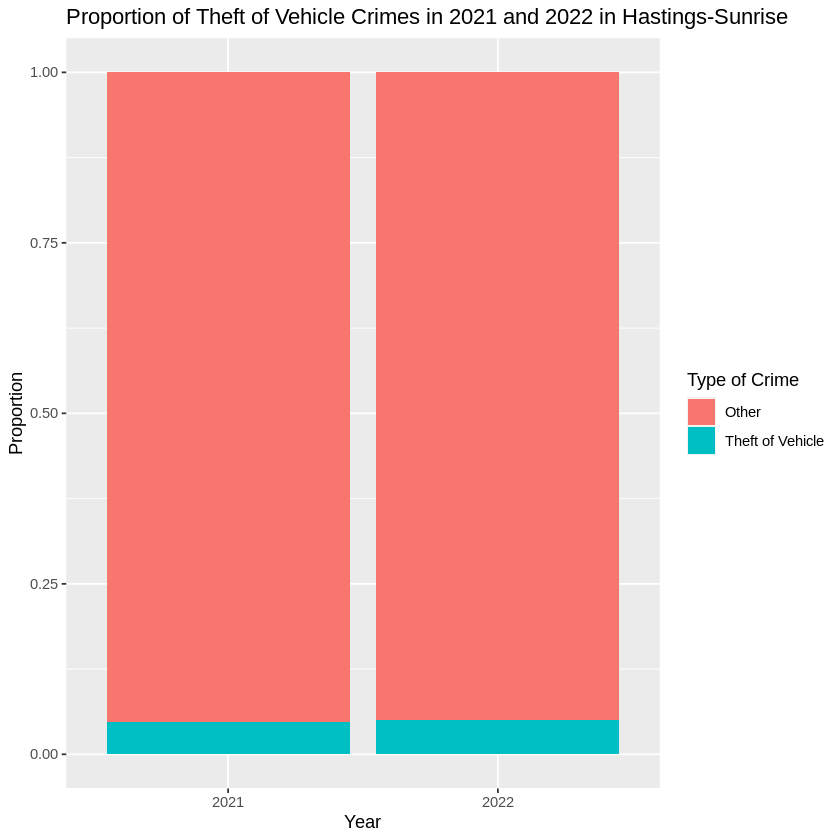

In [4]:
#Visualizing the proportion of crimes that were Theft of Vehicle
theft_vehicle_plot <- theft_vehicle %>%
    ggplot() +
        geom_bar(aes(x = YEAR, fill = TYPE), position = "fill") +
        labs(x = "Year", y = "Proportion", fill = "Type of Crime") +
        ggtitle("Proportion of Theft of Vehicle Crimes in 2021 and 2022 in Hastings-Sunrise")
theft_vehicle_plot

**Figure 1.** A bar graph of the proportion of crimes in 2021 and 2022 that were Theft of Vehicle in the Hastings-Sunrise neighbourhood. 

From this graph, it appears that there was a slight increase in the proportion of Theft of Vehicle in 2022 compared to 2021, however we cannot conclude whether this difference is significant or not. To do so, we will proceed with our hypothesis testing.

### Results

#### Hypothesis Tests & Confidence Intervals

We will be further studying how the proportion of crimes that were vehicle thefts in 2021 compare  the proportion of crimes that were vehicle thefts in 2022. To conduct this test, we are going to do a two-sample z-test to see if the proportion of 2022 higher than 2021.

In [22]:
compare_prop <- theft_vehicle|>
    group_by(YEAR)|>
    summarise(prop=mean(TYPE == "Theft of Vehicle"))
compare_prop

prop_2021 <- compare_prop$prop[1]
prop_2022 <- compare_prop$prop[1]

YEAR,prop
<fct>,<dbl>
2021,0.04729730
2022,0.05057956


#### Bootstraping Method

We will use boostraping method to compute a 90% confidence interval.

In [5]:
n_theft_vehicle <- theft_vehicle|> # computing n
    group_by(YEAR)|>
    summarise(n=n())
n_theft_vehicle

YEAR,n
<fct>,<int>
2021,1184
2022,949


In [31]:
#Creating 1000 bootstrap samples of size 1184 for the 2021 dataset and calculating the mean proportion
samples_2021 <- theft_vehicle|>
    filter(YEAR == 2021) |>
    rep_sample_n(size = 1184, reps = 1000, replace = TRUE) |>
    group_by(replicate) |>
    summarize(sample_pro = mean(TYPE == "Theft of Vehicle"))
head(samples_2021)

#Creating 1000 bootstrap samples of size 949 for the 2022 dataset and calculating the mean proportion
samples_2022 <- theft_vehicle|>
    filter(YEAR == 2022) |>
    rep_sample_n(size = 949, reps = 1000, replace = TRUE) |>
    group_by(replicate) |>
    summarize(sample_pro = mean(TYPE == "Theft of Vehicle"))
head(samples_2022)

replicate,sample_pro
<int>,<dbl>
1,0.05152027
2,0.04222973
3,0.04307432
4,0.05827703
5,0.04560811
6,0.04814189


replicate,sample_pro
<int>,<dbl>
1,0.04214963
2,0.05163330
3,0.05163330
4,0.04214963
5,0.05057956
6,0.06427819


In [14]:
# compute 90% confidence interval
ci_1 <- samples_2021 |> 
    summarize(ci_lower = quantile(sample_pro,0.05),
              ci_upper = quantile(sample_pro,0.95))
ci_1

ci_2 <- samples_2022 |> 
    summarize(ci_lower = quantile(sample_pro,0.05),
              ci_upper = quantile(sample_pro,0.95))
ci_2

ci_lower,ci_upper
<dbl>,<dbl>
0.03716216,0.05747466


ci_lower,ci_upper
<dbl>,<dbl>
0.04004215,0.06217071


This code create a plot of our bootstrapped data, overlaying it is our confidence interval and the true mean of each group from our sample.

In [42]:
ci_plot_1 <- 
    samples_2021 %>% 
    ggplot(aes(x = sample_pro)) +
    geom_histogram(colour = "black", fill = "grey", binwidth = 0.001) +
    annotate("rect", xmin = ci_1$ci_lower, xmax=ci_1$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = prop_2021,
               size = 2,
               colour = "red") +
    labs(title = "Bootstrapping Approximation of crimes that were vehicle thefts in 2021",
         x = "proportion of vehicle thefts",
         y = "Number of Observations")

ci_plot_2 <- 
    samples_2022 %>% 
    ggplot(aes(x = sample_pro)) +
    geom_histogram(colour = "black", fill = "grey", binwidth = 0.001) +
    annotate("rect", xmin = ci_2$ci_lower, xmax=ci_2$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = prop_2022,
               size = 2,
               colour = "red") +
    labs(title = "Bootstrapping Approximation of crimes that were vehicle thefts in 2022",
         x = "proportion of vehicle thefts",
         y = "Number of Observations")

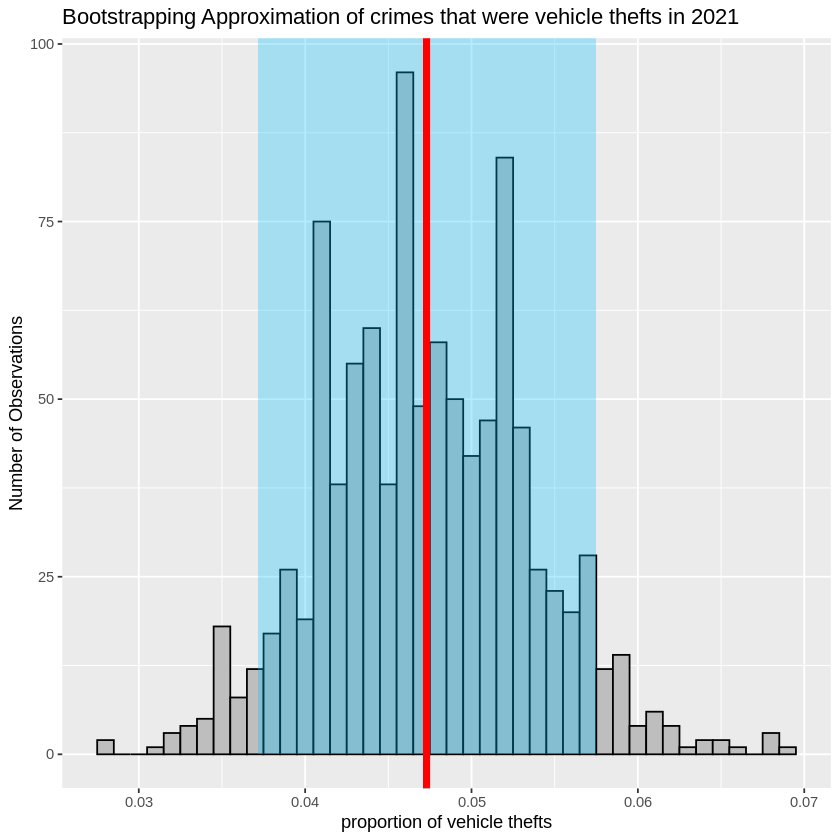

In [43]:
ci_plot_1

**Figure 2.**:Bootstrapping Approximation Graph
##### 90% confidence interval for Bootstrapping Method of vehicle thefts in 2021

In [44]:
tibble("Mean" = prop_2021,
               "Lower" = ci_1$ci_lower,
               "Upper" = ci_1$ci_upper)
     

Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
0.0472973,0.03716216,0.05747466


From the above confidence interval, we are 90% confident that the true mean proportion of crimes that were vehicle thefts in 2021 is between 0.03716216 and 0.05827703, which also indicates that our observed statistic falls in that range.

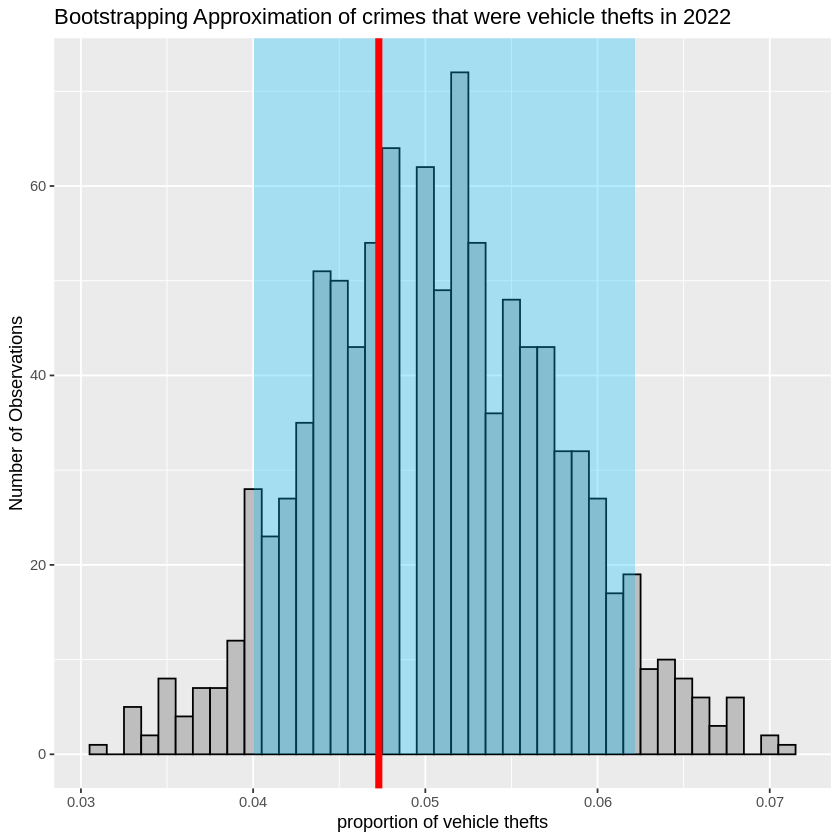

In [45]:
ci_plot_2 

**Figure 3.**:Bootstrapping Approximation Graph
##### 90% confidence interval for Bootstrapping Method of vehicle thefts in 2022

In [46]:
tibble("Mean" = prop_2022,
               "Lower" = ci_2$ci_lower,
               "Upper" = ci_2$ci_upper)

Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
0.0472973,0.04004215,0.06217071


From the above confidence interval, we are 90% confident that the true mean proportion of crimes that were vehicle thefts in 2022 is between 0.03793467 and 0.06217071, which also indicates that our observed statistic falls in that range.

#### CLT Method

Using the fact that as ${n}$ -> is large enough(np > 10 & n(1-p)>10), $X$ ~ $Normal(p_0, {\sqrt{p_0(1-p_0)/n}})$ to calculate the confidence interval.


In [88]:
# calculate the phat of 2021
theft_2021 <- theft_vehicle|>
    group_by(YEAR)|>
    summarise(prop=mean(TYPE == "Theft of Vehicle"))|>
    filter(YEAR == 2021)|>
    pull(prop)
    
    

# calculate the phat of 2021
theft_2022 <- theft_vehicle|>
    group_by(YEAR)|>
    summarise(prop=mean(TYPE == "Theft of Vehicle"))|>
    filter(YEAR == 2022)|>
    pull(prop)

# calculate the standard error of 2021
sd_2021 <- sqrt((theft_2021*(1-theft_2021))/1184)

# calculate the standard error of 2022
sd_2022 <- sqrt((theft_2022*(1-theft_2022))/949)


##### 90% confidence interval for Bootstrapping Method of vehicle thefts in 2021

In [82]:
tibble("Mean" = theft_2021,
               "Lower" = qnorm(0.025, theft_2021, sd_2021),
               "Upper" = qnorm(0.95 + 0.025, theft_2021, sd_2021))

Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
0.0472973,0.03520611,0.05938849


From above table, we are 90% confident that the true mean proportion of crimes that were vehicle thefts in 2021 is between 0.03520611 and 0.05938849, which also indicates that our observed statistic falls in that range.

##### 90% confidence interval for Bootstrapping Method of vehicle thefts in 2022

In [90]:
tibble("Mean" = theft_2022,
               "Lower" = qnorm(0.025, theft_2022, sd_2022),
               "Upper" = qnorm(0.95 + 0.025, theft_2022, sd_2022))

Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
0.05057956,0.03663734,0.06452177


From above table, we are 90% confident that the true mean proportion of crimes that were vehicle thefts in 2021 is between 0.03663734 and 0.06452177, which also indicates that our observed statistic falls in that range.

#### Hypothesis Testing

- $H_0$:there is no difference in the proportion of crimes that were vehicle thefts between 2021 and 2022.
- $H_A$: The proportion of crimes that were vehicle thefts in 2022 is heigher than 2021.
- Significance Level : 0.05

##### Two-Sample Z-test Result

In [99]:
# Calculate the number of crime which type is Theft of Vehicle
# respectively in 2021 and 2022 and the total number of the crimes
# in 2021 and 2022
n_2021 <- nrow(crime_data_2021)

n_2022 <- nrow(crime_data_2022)

n_2021_tov <- crime_data_2021|>
    filter(TYPE == "Theft of Vehicle") |>
    nrow()


n_2022_tov <- crime_data_2022|>
    filter(TYPE == "Theft of Vehicle") |>
    nrow()

# Calculate the Theft from Vehicle respectively in 2021 and 2022
p_2021 <- n_2021_tov/n_2021
p_2022 <- n_2022_tov/n_2022

#Finally let us do the prop test
prop_test <- tidy(
        prop.test(x = c(n_2021_tov, n_2022_tov), # an array with the number of successes in each sample
                  n = c(n_2021, n_2022), # an array with the size of each sample
                  correct = FALSE, alternative = "greater"))
prop_test

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.0472973,0.05057956,0.12236,0.6367556,1,-0.01877008,1,2-sample test for equality of proportions without continuity correction,greater


##### p_value

Our P-value is 0.6367556. Since the p-value is greater than the chosen significance level, we can not reject the Null Hypothesis, which means there is not enough evidence to show that the alternative hypothesis is correct. Specifically, the proportion of theft of vehicles from 2021 in the Hastings-Sunrise neighbourhood is not greater than 2021.

### Discussion

### References

Cohn, S. (2021, June 18). With car prices surging, yours is a prime target for thieves. *CNBC*. [Accessed 2023, April 09]. https://www.cnbc.com/2021/06/18/with-car-prices-surging-yours-is-a-prime-target-for-thieves-.html.

Crime Data in Hastings-Sunrise. *VPD Open Data*. [Accessed 2023, April 09]. https://geodash.vpd.ca/opendata/.  

Crime Statistics. *Vancouver Police Department*. [Accessed 2023, April 09]. https://vpd.ca/crime-statistics/. 

Macklem, T. (2022, October 06). What’s happening to inflation and why it matters. *Bank of Canada*. [Accessed 2023, April 09]. https://www.bankofcanada.ca/2022/10/whats-happening-to-inflation-and-why-it-matters.

Rosenfeld, R. (2014). Crime and Inflation in Cross-National Perspective. *Crime and Justice: Review of Research, 43*, 341-366.

Tang, C. F., & Lean, H. H. (2007). Will Inflation Increase Crime Rate? New Evidence from Bounds and Modified Wald Tests. *Global Crime, 8*(4), 311-323. https://doi.org/10.1080/17440570701739694.